In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'indias-air-quality-index:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1662185%2F2726973%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T155459Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9afd8246cfd0b737feafca9602253afb344b3cc62a599ea808e82f454ef2ae1fbc3f704a118729ecf8de73c63bb0873116d5bd107387e8fbe6bf2a3bceb17b1f922103793529aa98c0b3d7012b7f73f9b83fee9cdf68021c83c6bc50405b38ac4e674b3387a49d03af1f2c50712f63a7dfc8180bec339613a3518e855a7e1083d6b09535eee87f6d6e60b81e49432e5d94c724e28d5353affb43e04b7d39ce701d81ae4221a65b41ab1563d3c7683aead5d3e6d617dc8ea7e280424697d41e1f672ca69cae79ec6c3e756eb3936ce6130ada9f45adec3d8ec103a9683b825a654cf91784f9ec34507a95a733ba7032a2e9b8245aa09904f2d8ac7236bb2a3002'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 24353 bytes downloaded
Downloaded and uncompressed: indias-air-quality-index
Data source import complete.


<h1 id ="libraries" style="color:#2FDD92;">Libraries</h1>

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from folium.plugins import HeatMap
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
plt.style.use('fivethirtyeight')

/kaggle/input/indias-air-quality-index/Air_Quality.csv


<h1 id ="libraries" style="color:#2FDD92;">Load Data</h1>

In [3]:
df = pd.read_csv('/content/Air_Quality.csv')
df.head()

,id,country,state,city,station,pollutant_id,last_update,pollutant_min,pollutant_max,pollutant_avg
0,1,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",PM2.5,21-10-2021 01:00:00,69.0,109.0,86.0
1,2,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",PM10,21-10-2021 01:00:00,82.0,138.0,105.0
2,3,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",NO2,21-10-2021 01:00:00,10.0,42.0,19.0
3,4,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",NH3,21-10-2021 01:00:00,4.0,5.0,4.0
4,5,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",SO2,21-10-2021 01:00:00,16.0,42.0,27.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1836 non-null   int64  
 1   country        1836 non-null   object 
 2   state          1836 non-null   object 
 3   city           1836 non-null   object 
 4   station        1836 non-null   object 
 5   pollutant_id   1836 non-null   object 
 6   last_update    1836 non-null   object 
 7   pollutant_min  1738 non-null   float64
 8   pollutant_max  1738 non-null   float64
 9   pollutant_avg  1738 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 143.6+ KB


### Percent of missing values

In [5]:
df.isna().mean().round(4) * 100

id               0.00
country          0.00
state            0.00
city             0.00
station          0.00
pollutant_id     0.00
last_update      0.00
pollutant_min    5.34
pollutant_max    5.34
pollutant_avg    5.34
dtype: float64

<ipython-input-6-686f67e6e24b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=g,x='city',y='pollutant_avg',palette='magma',linewidth=10)


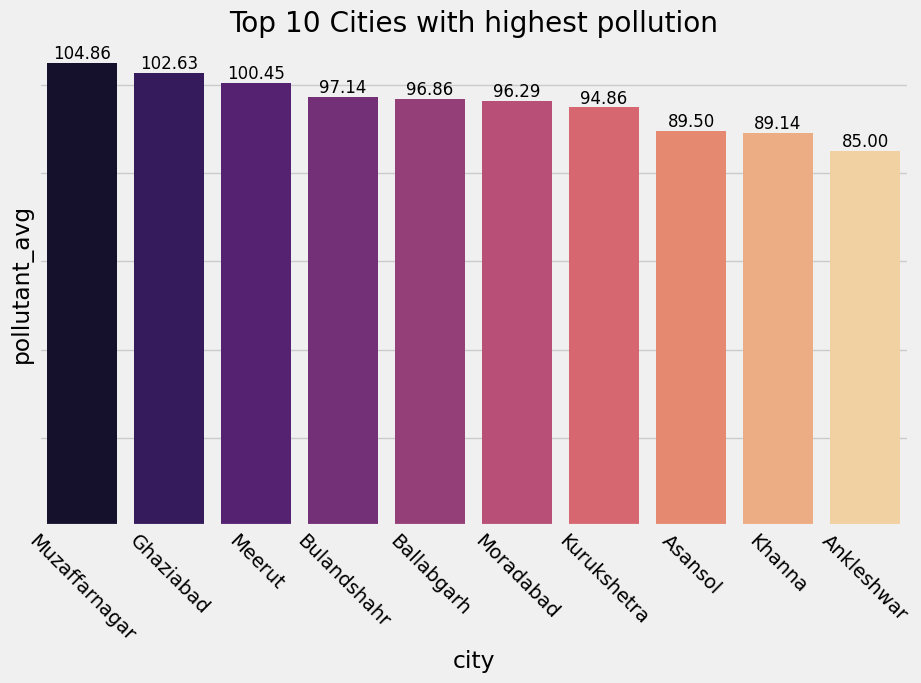

In [6]:
plt.figure(figsize=(10, 6))


g=df.groupby(['city'])['pollutant_avg'].mean().nlargest(10).reset_index()
clrs = ['grey' if (x < max(g.pollutant_avg)) else 'red' for x in g.pollutant_avg.values]
ax=sns.barplot(data=g,x='city',y='pollutant_avg',palette='magma',linewidth=10)
for p in ax.patches:
    ax.annotate(format((p.get_height()), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='top',
                   size=12,
                   xytext=(0, 13),
                   textcoords='offset points')
plt.tick_params(left = False,labelleft = False)
plt.xticks(rotation=315)
plt.title('Top 10 Cities with highest pollution')
plt.show()

<ipython-input-7-fc4657eca54c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=g,x='city',y='pollutant_avg',palette='YlGn')


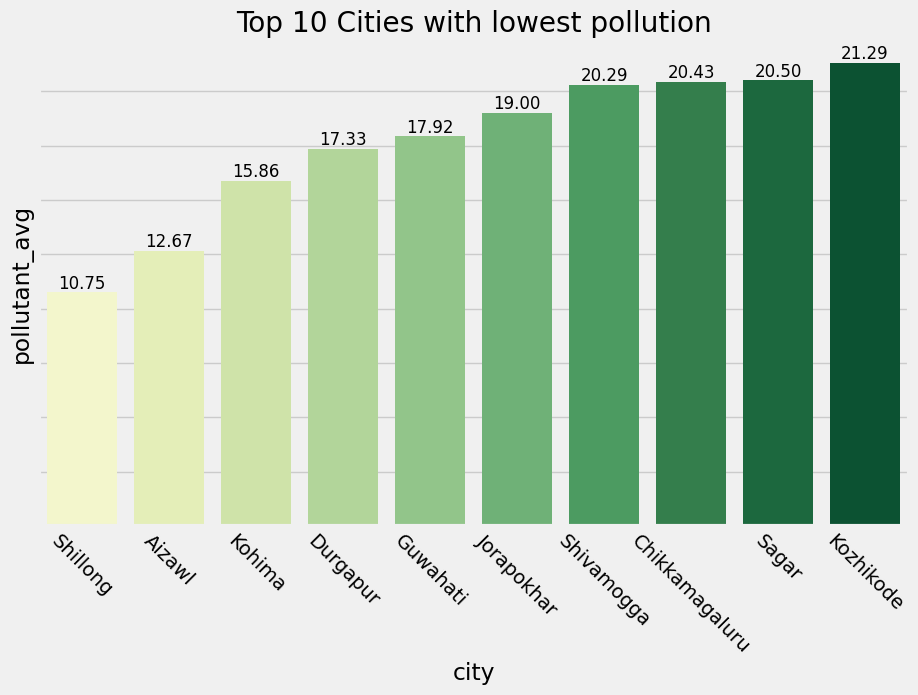

In [7]:
plt.figure(figsize=(10, 6))
palette = sns.light_palette("seagreen", as_cmap=True)
g=df.groupby(['city'])['pollutant_avg'].mean().nsmallest(10).reset_index()
ax=sns.barplot(data=g,x='city',y='pollutant_avg',palette='YlGn')
for p in ax.patches:
    ax.annotate(format((p.get_height()), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='top',
                   size=12,
                   xytext=(0, 13),
                   textcoords='offset points')
plt.tick_params(left = False,labelleft = False)
plt.xticks(rotation=315)
plt.title('Top 10 Cities with lowest pollution')
plt.show()

<h1 id ="libraries" style="color:#2FDD92;">Get Latitude and Longitude using City Name </h1>


In [8]:
geolocator = Nominatim(timeout=1, user_agent = "myGeolocator")
grouped_city = df.groupby(['city'])['pollutant_avg'].mean().reset_index()
def geocode_my_address(addr):
#     print('geocoding:', addr)
    try:
        x = geolocator.geocode(addr)
        lon_lat = x.longitude, x.latitude
        return lon_lat
    except:
#         print("problem with address:", addr)
        lon_lat = None, None
        return lon_lat

grouped_city['lon'], grouped_city['lat'] = zip(*grouped_city['city'].apply(lambda x: geocode_my_address(x)))

In [12]:
city_map = folium.Map(location=[19.667417,76.827826],
                       tiles = "Stamen Toner",
                      zoom_start = 5)

data_heatmap = grouped_city[['lat','lon']]
data_heatmap = grouped_city.dropna(axis=0, subset=['lat','lon'])
data_heatmap = [[row['lat'],row['lon']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=15).add_to(city_map)

city_map

<ipython-input-10-e6a85e348697>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=g,x='state',y='pollutant_avg',palette='magma',linewidth=10)


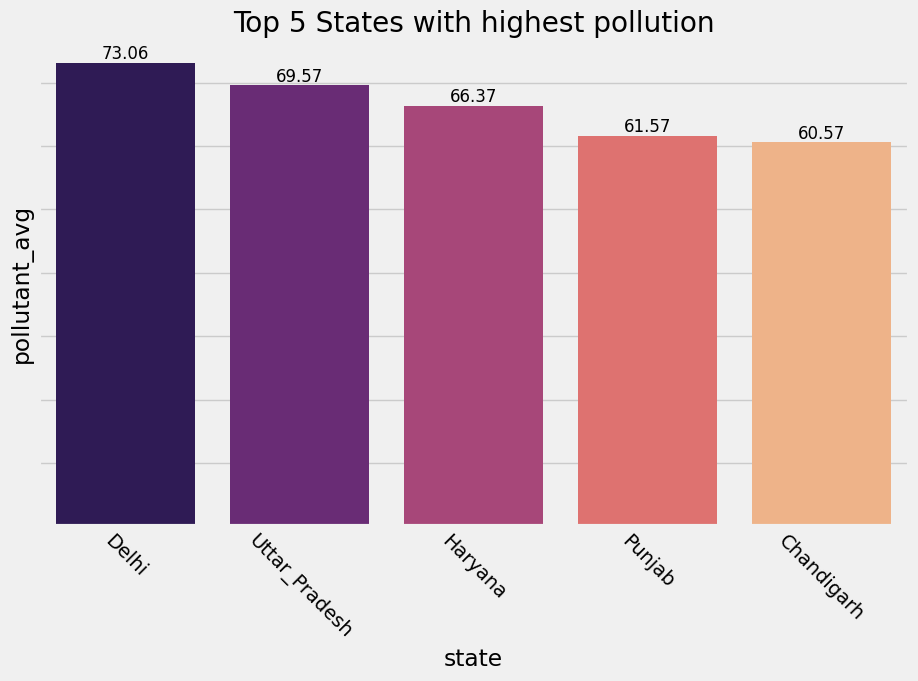

In [10]:
plt.figure(figsize=(10, 6))


g=df.groupby(['state'])['pollutant_avg'].mean().nlargest(5).reset_index()
clrs = ['grey' if (x < max(g.pollutant_avg)) else 'red' for x in g.pollutant_avg.values]
ax=sns.barplot(data=g,x='state',y='pollutant_avg',palette='magma',linewidth=10)
for p in ax.patches:
    ax.annotate(format((p.get_height()), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='top',
                   size=12,
                   xytext=(0, 13),
                   textcoords='offset points')
plt.tick_params(left = False,labelleft = False)
plt.xticks(rotation=315)
plt.title('Top 5 States with highest pollution')
plt.show()

<ipython-input-11-d915bdc81ef0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=g,x='state',y='pollutant_avg',palette='YlGn')


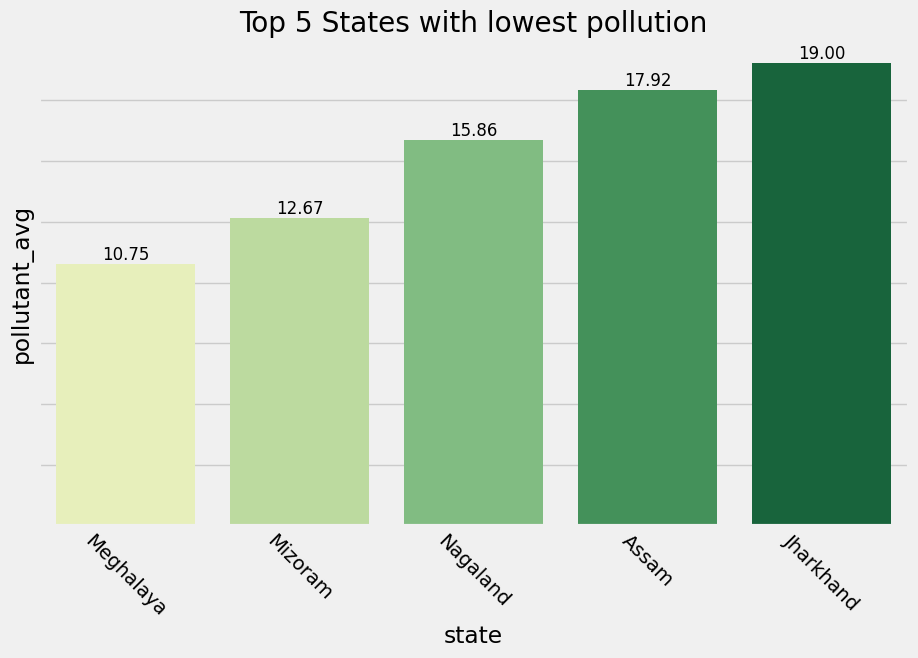

In [11]:
plt.figure(figsize=(10, 6))
palette = sns.light_palette("seagreen", as_cmap=True)
g=df.groupby(['state'])['pollutant_avg'].mean().nsmallest(5).reset_index()
ax=sns.barplot(data=g,x='state',y='pollutant_avg',palette='YlGn')
for p in ax.patches:
    ax.annotate(format((p.get_height()), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='top',
                   size=12,
                   xytext=(0, 13),
                   textcoords='offset points')
plt.tick_params(left = False,labelleft = False)
plt.xticks(rotation=315)
plt.title('Top 5 States with lowest pollution')
plt.show()